In [150]:
import pandas as pd
import numpy as np
from random import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [151]:
salaries = pd.read_csv("/content/kaggle_survey_2022_responses.csv")
# Drop rows where Q29 is missing or empty
salaries = salaries[salaries["Q29"].notna() & (salaries["Q29"].str.strip() != "")]
salaries.shape

(8137, 296)

# Question 1: Data Cleaning

- Drop the second row since it is about the question details
- Drop other information too if they are irrelevant to the task

In [152]:
# # Convert duration column to numeric (if not already)
# salaries["Duration (in seconds)"] = pd.to_numeric(salaries["Duration (in seconds)"], errors='coerce')

# # Check correlation with salary (Q29_Encoded)
# if "Q29_Encoded" in salaries.columns:
#     correlation = salaries["Duration (in seconds)"].corr(salaries["Q29_Encoded"])
# else:
#     correlation = None

# # Plot distribution of duration
# plt.figure(figsize=(10, 5))
# sns.histplot(salaries["Duration (in seconds)"], bins=50, kde=True)
# plt.xlabel("Survey Duration (seconds)")
# plt.ylabel("Frequency")
# plt.title("Distribution of Survey Duration")
# plt.show()

# # Display correlation result
# correlation

In [153]:
def CleanData(df):
    """
    Cleans the dataset by:
    1. Dropping the first row containing question details.
    2. Dropping the 'Duration (in seconds)' column as it is not predictive of salary.
    3. Removing completely empty columns.
    """

    # Drop the first row containing question details
    df.drop(index=0, inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Drop 'Duration (in seconds)' since it is not predictive of salary
    if "Duration (in seconds)" in df.columns:
        df.drop(columns=["Duration (in seconds)"], inplace=True)

    # Identify and drop completely empty columns -- answered None
    empty_columns = df.columns[df.isna().all()].tolist()
    if empty_columns:
        df.drop(columns=empty_columns, inplace=True)
        print(f"Dropped completely empty columns: {empty_columns}")
    else:
        print("No completely empty columns found.")

    return df

salaries = CleanData(salaries)

Dropped completely empty columns: ['Q6_11', 'Q12_14', 'Q13_13', 'Q14_15', 'Q15_14', 'Q17_14', 'Q18_13', 'Q19_7', 'Q20_5', 'Q31_11', 'Q35_15', 'Q36_14', 'Q39_11', 'Q41_8', 'Q42_8', 'Q44_11']


In [154]:
# How to check if the CleanData() did what I want?
salaries

,Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,...,Q44_2,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_12
0,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,NaN,...,NaN,NaN,"Kaggle (notebooks, forums, etc)","Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN
1,30-34,Man,Germany,No,Coursera,edX,NaN,NaN,NaN,Udacity,...,"Email newsletters (Data Elixir, O'Reilly Data ...","Reddit (r/machinelearning, etc)",NaN,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN
2,70+,Man,Australia,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,NaN,...,"Email newsletters (Data Elixir, O'Reilly Data ...",NaN,NaN,NaN,NaN,"Podcasts (Chai Time Data Science, O’Reilly Dat...",NaN,NaN,NaN,NaN
3,40-44,Man,United States of America,No,Coursera,NaN,Kaggle Learn Courses,NaN,Fast.ai,Udacity,...,"Email newsletters (Data Elixir, O'Reilly Data ...",NaN,NaN,NaN,NaN,"Podcasts (Chai Time Data Science, O’Reilly Dat...","Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN
4,40-44,Man,United States of America,No,Coursera,NaN,NaN,NaN,NaN,Udacity,...,NaN,NaN,NaN,NaN,NaN,"Podcasts (Chai Time Data Science, O’Reilly Dat...","Blogs (Towards Data Science, Analytics Vidhya,...","Journal Publications (peer-reviewed journals, ...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8131,40-44,Man,United States of America,No,NaN,NaN,Kaggle Learn Courses,DataCamp,NaN,NaN,...,NaN,NaN,"Kaggle (notebooks, forums, etc)",NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN
8132,35-39,Man,India,No,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,NaN,NaN,NaN,NaN
8133,40-44,Man,India,No,NaN,NaN,NaN,DataCamp,NaN,NaN,...,NaN,NaN,NaN,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,NaN,NaN,NaN,NaN
8134,25-29,Man,Turkey,No,NaN,NaN,NaN,DataCamp,NaN,NaN,...,NaN,NaN,"Kaggle (notebooks, forums, etc)",NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,NaN,NaN,NaN,NaN


### **Impute missing values (single column responses)**

1. Identify columns with single column responses

2. Address missing values in those columns

In [155]:
def ImputingSingleColMissingValues(df):
    """
    Handles missing values in single-column responses by:
    1. Identifying single-column response features (excluding multi-column responses).
    2. Filling missing values in:
       - Numerical columns → Median value.
       - Categorical columns → "Unknown".
    3. Printing the list of identified single-column response features.
    """

    # Identify all column names without an underscore
    single_col_responses = [col for col in df.columns if "_" not in col]

    print("Single Column Responses:", single_col_responses)

    # Fill missing values for numerical columns in single-column responses
    for col in single_col_responses:
        if df[col].dtype in ["int64", "float64"] and df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)

    # Fill missing values for categorical columns in single-column responses
    for col in single_col_responses:
        if df[col].dtype == "object" and df[col].isnull().sum() > 0:
            df[col].fillna("Unknown", inplace=True)

    return df

salaries = ImputingSingleColMissingValues(salaries)
salaries.shape

Single Column Responses: ['Q2', 'Q3', 'Q4', 'Q5', 'Q8', 'Q9', 'Q11', 'Q16', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q29', 'Q30', 'Q32', 'Q43']


(8136, 279)

In [156]:
# missing_values_summary = salaries[single_col_responses].isnull().sum()

# # Check if all values are now non-null
# all_imputed = missing_values_summary.sum() == 0

# # Print results
# print("Missing Values After Imputation:")
# print(missing_values_summary)

### **Encode categorical features (sinlge column responses)**

In [157]:
# Encode categorical features in the single column responses

def EncodeCategoricalFeatures(df):
    """
    Encodes categorical single-response columns:
    1. Applies Ordinal Encoding to detected ordinal categorical features.
    2. Converts categorical columns to string type to prevent encoding errors.
    3. Applies Label Encoding to nominal categorical features.
    4. Prints the columns that were encoded.
    """

    # Identify categorical columns without underscores (single-response categorical features)
    categorical_cols = [col for col in df.columns if "_" not in col]

    # Ensure all categorical values are converted to strings to prevent mixed types
    df[categorical_cols] = df[categorical_cols].astype(str)

    # Custom mapping for Q29 into 15 ordinal bins
    q29_bins = {
        "$0-999": 0,
        "1,000-1,999": 1,
        "2,000-2,999": 2,
        "3,000-3,999": 3,
        "4,000-4,999": 4,
        "5,000-7,499": 5,
        "7,500-9,999": 6,
        "10,000-14,999": 7,
        "15,000-19,999": 8,
        "20,000-24,999": 9,
        "25,000-29,999": 10,
        "30,000-39,999": 11,
        "40,000-49,999": 11,
        "50,000-59,999": 11,
        "60,000-69,999": 11,
        "70,000-79,999": 11,
        "80,000-89,999": 11,
        "90,000-99,999": 11,
        "100,000-124,999": 12,
        "125,000-149,999": 12,
        "150,000-199,999": 12,
        "200,000-249,999": 13,
        "250,000-299,999": 13,
        "300,000-499,999": 13,
        "$500,000-999,999": 13,
        ">$1,000,000": 14,
    }

    # Clean and encode Q29 into Q29_Encoded
    if "Q29" in df.columns:
        df["Q29_Encoded"] = df["Q29"].map(q29_bins)
        df["Q29_Encoded"] = df["Q29_Encoded"].astype(int)

    # Dictionary to store detected ordinal categorical columns with predefined rankings
    ordinal_mappings = {
        "Q8": [
            "No formal education past high school",
            "Some college/university study without earning a bachelor’s degree",
            "Bachelor’s degree",
            "Master’s degree",
            "Doctoral degree",
            "Professional doctorate",
        ],
        "Q11": [
            "I have never written code",
            "< 1 years",
            "1-3 years",
            "3-5 years",
            "5-10 years",
            "10-20 years",
            "20+ years",
        ],
        "Q16": [
            "I do not use machine learning methods",
            "Under 1 year",
            "1-2 years",
            "2-3 years",
            "3-4 years",
            "4-5 years",
            "5-10 years",
            "10-20 years",
            "20 or more years",
        ],
        "Q25": [
            "0-49 employees",
            "50-249 employees",
            "250-999 employees",
            "1000-9,999 employees",
            "10,000 or more employees",
        ],
        "Q26": [
            "0",
            "45659", # Originally 1-2,
            "45720", # 3-4,
            "45786", # 5-9,
            "45944", # 10-14
            "15-19",
            "20+",
        ],
        "Q27": [
            "No (we do not use ML methods)",
            "We are exploring ML methods (and may one day put a model into production)",
            "We use ML methods for generating insights (but do not put working models into production)",
            "We recently started using ML methods (i.e., models in production for less than 2 years)",
            "We have well established ML methods (i.e., models in production for more than 2 years)",
        ],
        "Q30": [
            "$0 ($USD)",
            "$1-$99",
            "$100-$999",
            "$1000-$9,999",
            "$10,000-$99,999",
            "$100,000 or more ($USD)",
        ],
    }

    # Apply ordinal encoding to the detected ordinal columns
    for col, categories in ordinal_mappings.items():
        if col in df.columns:
            df[col] = df[col].astype(pd.CategoricalDtype(categories=categories, ordered=True))
            df[col] = df[col].cat.codes  # Convert to numeric encoding

    # Handle Q4 (Country) - Keep only the top N most frequent countries, group others as "Other"
    if "Q4" in df.columns:
        top_countries = df["Q4"].value_counts().nlargest(5).index.tolist()
        df["Q4"] = df["Q4"].apply(lambda x: x if x in top_countries else "Other")

    # Identify nominal categorical columns (excluding ordinal ones and Q29)
    nominal_columns = [
    col for col in categorical_cols
    if col not in ordinal_mappings and col != "Q29" and col in df.columns]

    print("Ordinal Encoded Columns:", list(ordinal_mappings.keys()) + ["Q29"])
    print("One-Hot Encoded Columns:", nominal_columns)

    # Apply One-Hot Encoding to nominal categorical variables
    df = pd.get_dummies(df, columns=nominal_columns, drop_first=True)  # Drop first category to avoid multicollinearity

    # Convert any boolean columns (from get_dummies) to integers (0/1)
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(int)

    return df

salaries = EncodeCategoricalFeatures(salaries)

Ordinal Encoded Columns: ['Q8', 'Q11', 'Q16', 'Q25', 'Q26', 'Q27', 'Q30', 'Q29']
One-Hot Encoded Columns: ['Q2', 'Q3', 'Q4', 'Q5', 'Q9', 'Q22', 'Q23', 'Q24', 'Q32', 'Q43']


### **Handling categorical features (multi column responses)**

In [158]:
def HandleMultiColumnResponses(df):
    """
    Processes multi-response categorical questions:
    - Dynamically identifies raw multi-response columns (those with underscores).
    - Excludes ordinal encoded and one-hot encoded columns.
    - Converts NaNs to 0 (not selected) and values to 1 (selected).
    """

    # Define the base columns that were one-hot encoded
    one_hot_base_cols = ['Q2', 'Q3', 'Q4', 'Q5', 'Q9', 'Q22', 'Q23', 'Q24', 'Q32', 'Q43']

    # Define ordinal encoded columns (Q29 is ordinal-encoded to Q29_Encoded)
    ordinal_encoded_cols = ['Q8', 'Q11', 'Q16', 'Q25', 'Q26', 'Q27', 'Q30', 'Q29']

    # Prepare prefixes to filter out
    one_hot_prefixes = [col + "_" for col in one_hot_base_cols]
    ordinal_prefixes = [col + "_" for col in ordinal_encoded_cols]

    # Dynamically find all multi-response columns
    multi_response_cols = [
        col for col in df.columns
        if (
            "_" in col and
            col != "Q29_Encoded" and
            not any(col.startswith(prefix) for prefix in one_hot_prefixes) and
            not any(col.startswith(prefix) for prefix in ordinal_prefixes)
        )
    ]

    print("Multi-Response Columns:", multi_response_cols)

    # Impute: NaN → 0 (not selected), value → 1 (selected)
    df[multi_response_cols] = df[multi_response_cols].notna().astype(int)

    return df

salaries = HandleMultiColumnResponses(salaries)

Multi-Response Columns: ['Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q6_7', 'Q6_8', 'Q6_9', 'Q6_10', 'Q6_12', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5', 'Q7_6', 'Q7_7', 'Q10_1', 'Q10_2', 'Q10_3', 'Q12_1', 'Q12_2', 'Q12_3', 'Q12_4', 'Q12_5', 'Q12_6', 'Q12_7', 'Q12_8', 'Q12_9', 'Q12_10', 'Q12_11', 'Q12_12', 'Q12_13', 'Q12_15', 'Q13_1', 'Q13_2', 'Q13_3', 'Q13_4', 'Q13_5', 'Q13_6', 'Q13_7', 'Q13_8', 'Q13_9', 'Q13_10', 'Q13_11', 'Q13_12', 'Q13_14', 'Q14_1', 'Q14_2', 'Q14_3', 'Q14_4', 'Q14_5', 'Q14_6', 'Q14_7', 'Q14_8', 'Q14_9', 'Q14_10', 'Q14_11', 'Q14_12', 'Q14_13', 'Q14_14', 'Q14_16', 'Q15_1', 'Q15_2', 'Q15_3', 'Q15_4', 'Q15_5', 'Q15_6', 'Q15_7', 'Q15_8', 'Q15_9', 'Q15_10', 'Q15_11', 'Q15_12', 'Q15_13', 'Q15_15', 'Q17_1', 'Q17_2', 'Q17_3', 'Q17_4', 'Q17_5', 'Q17_6', 'Q17_7', 'Q17_8', 'Q17_9', 'Q17_10', 'Q17_11', 'Q17_12', 'Q17_13', 'Q17_15', 'Q18_1', 'Q18_2', 'Q18_3', 'Q18_4', 'Q18_5', 'Q18_6', 'Q18_7', 'Q18_8', 'Q18_9', 'Q18_10', 'Q18_11', 'Q18_12', 'Q18_14', 'Q19_1', 'Q19_2', 'Q19_3',

### **Drop the target variable(s) and get the target variable**

In [159]:
# Make sure there are no missing values remaining in the dataset
assert salaries.isnull().values.sum() == 0, \
    "There are still {} missing values remaining in salaries!".format(
        salaries.isnull().values.sum()
    )

In [160]:
# Extract the target variable (Q29_Encoded)
target = salaries["Q29_Encoded"]

# Drop target-related columns (Q29, Q29_Encoded, Q29_buckets) from the feature set
salaries = salaries.drop(columns=["Q29", "Q29_Encoded"], errors="ignore")

# Make sure the target variables are not included in the feature set
for col in salaries.columns:
    assert 'Q29' not in col, \
        "Target variable ({}) is still in the dataset".format(col)

# Question 2: Exploratory Feature Analysis

- From Question 2 - Question 4, you should **NOT** peek at the test labels in any form!
- Assume that you do not know the target values (Q29_Encoded) on the test set

## Split data into training and test sets

In [161]:
# Split data into training and test sets (80% train, 20% test)
train_df, test_df, y_train, y_test = train_test_split(salaries, target, test_size=0.2, random_state=42)

# Print dataset sizes for verification
print(f"Train set size: {train_df.shape}, Test set size: {test_df.shape}")
print(f"Target train size: {y_train.shape}, Target test size: {y_test.shape}")

Train set size: (6508, 342), Test set size: (1628, 342)
Target train size: (6508,), Target test size: (1628,)


## **Feature Engineering/Generation**

- Create new feature(s) using existing features!

In [162]:
# Create new features (feature generation)

# Define advanced ML algorithms based on Q18 options
advanced_q18_cols = [
    "Q18_6",  # Dense Neural Networks
    "Q18_7",  # Convolutional Neural Networks
    "Q18_8",  # GANs
    "Q18_9",  # RNNs
    "Q18_10", # Transformers
    "Q18_11", # Autoencoders
    "Q18_12", # Graph Neural Networks
]

# Create the feature based on whether any advanced method is selected
train_df["uses_advanced_ml"] = train_df[advanced_q18_cols].any(axis=1).astype(int)

In [163]:
# # Save the training dataframe after feature engineering
# train_df.to_csv("train_df_engineered.csv", index=False)

## **Feature Selection**

- Select the features based on the criteria of your choice

In [164]:
from sklearn.feature_selection import mutual_info_classif

# Compute mutual information scores
mi_scores = mutual_info_classif(train_df, y_train, discrete_features=True)
mi_scores = pd.Series(mi_scores, index=train_df.columns).sort_values(ascending=False)

# Select the top 10 features based on MI scores
selected_features = mi_scores.index[:10].tolist()

print("\nFeature selection completed! Selected features based on Mutual Information:")
print(selected_features)


Feature selection completed! Selected features based on Mutual Information:
['Q4_United States of America', 'Q11', 'Q16', 'Q4_India', 'Q30', 'Q27', 'Q26', 'Q28_3', 'Q34_3', 'Q25']


In [165]:
train_df_selected = train_df[selected_features]

## **Visualization**

- Make visualization to better understand your data

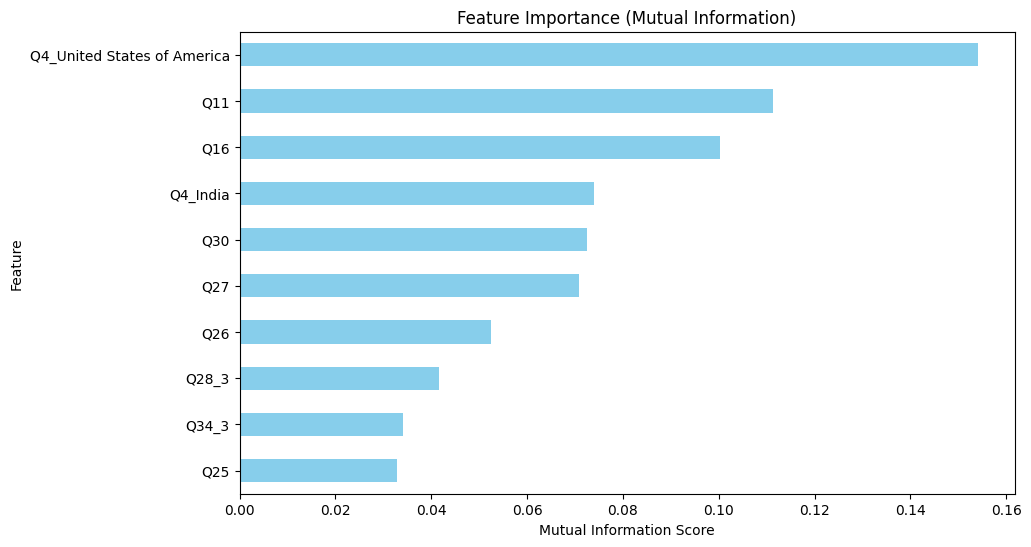

In [166]:
# Plot Mutual Information Scores
plt.figure(figsize=(10, 6))
mi_scores[:10].plot(kind='barh', color='skyblue')
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.title("Feature Importance (Mutual Information)")
plt.gca().invert_yaxis()  # Flip order for better visualization
plt.show()

## **Apply the same feature engineering/selection to test data**

In [167]:
# Create "uses_advanced_ml" in the test set just like training set
test_df["uses_advanced_ml"] = test_df[advanced_q18_cols].any(axis=1).astype(int)

# Keep only the previously selected features
test_df_selected = test_df[selected_features]

In [168]:
X_train = train_df_selected.values
X_test = test_df_selected.values
y_train = y_train.values
y_test = y_test.values

# Question 3: Model Implementation

## Implement Ordinal Logistic Regression Model

In [169]:
class OrdinalLogisticRegression():
    """
    Implements ordinal logistic regression using k-1 binary logistic classifiers.
    """

    def __init__(self, max_iter=100, C=1.0):
        """
        Initialize the Ordinal Logistic Regression model.

        Parameters:
        - max_iter: Maximum number of iterations for logistic regression training.
        - C: Regularization strength (higher C reduces regularization, lower C increases regularization).
        """
        self.C = C  # Regularization parameter for bias-variance tradeoff
        self.max_iter = max_iter
        self.classes_ = []
        self.models_ = []

    def fit(self, X, y):
        """
        Fit k-1 binary logistic regression models for ordinal classification.

        Parameters:
        - X: Feature matrix.
        - y: Target vector (ordinal labels).
        """
        self.classes_ = sorted(np.unique(y))  # Get unique class labels in order
        self.models_ = []

        # Train k-1 binary logistic regression models
        for i, c in enumerate(self.classes_[:-1]):  # We need k-1 classifiers
            y_i = (y > c).astype(int)  # Convert ordinal labels to binary: 0 if y ≤ c, 1 otherwise
            model = LogisticRegression(max_iter=self.max_iter, C=self.C)  # Base binary classifier
            model.fit(X, y_i)  # Train model on transformed labels
            self.models_.append(model)

        return self

    def predict_proba(self, X):
        """
        Predict probability estimates for each ordinal class.

        Parameters:
        - X: Feature matrix.

        Returns:
        - proba: Probability distribution over ordinal classes.
        """
        assert len(self.models_) > 0, "Model is not fitted yet. Run .fit() first."

        # Store probabilities for k-1 binary classifiers
        binary_probabilities = np.empty((X.shape[0], len(self.models_), 2), dtype=float)

        # Get probability predictions for each binary classifier
        for i, model in enumerate(self.models_):
            binary_probabilities[:, i] = model.predict_proba(X)  # Get probability estimates

        # Compute full ordinal probabilities
        k = len(self.classes_)
        proba = np.empty((X.shape[0], k), dtype=float)  # Stores final class probabilities

        # Compute class probabilities from binary models
        proba[:, 0] = binary_probabilities[:, 0, 0]  # Probability of first class

        for i in range(1, k-1):
            proba[:, i] = binary_probabilities[:, i, 0] - binary_probabilities[:, i-1, 0]

        proba[:, -1] = binary_probabilities[:, k-2, 1]  # Probability of last class

        # Ensure probabilities sum to 1
        assert np.allclose(proba.sum(axis=1), 1), "Probability computation error!"

        return proba

    def predict(self, X):
        """
        Predict the most likely class for each instance.

        Parameters:
        - X: Feature matrix.

        Returns:
        - Predicted ordinal class labels.
        """
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)  # Return the class with the highest probability

    def get_params(self, deep=True):
        """
        Retrieve hyperparameters for tuning.

        Returns:
        - Dictionary of hyperparameters.
        """
        return {'max_iter': self.max_iter, 'C': self.C}  # Added regularization parameter C

    def set_params(self, **parameters):
        """
        Set hyperparameters dynamically.

        Parameters:
        - parameters: Dictionary of hyperparameter values.
        """
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


## Run k-fold cross validation

- Report the average/variance of accuracies across folds

In [170]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Number of folds for cross-validation
k_folds = 10

# Initialize K-Fold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize list to store accuracies
accuracies = []

# Perform 10-fold cross-validation
for train_index, val_index in kf.split(train_df_selected):
    X_train, X_val = train_df_selected.iloc[train_index], train_df_selected.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Initialize and train the ordinal logistic regression model
    model = OrdinalLogisticRegression(max_iter=200, C=1.0)  # Using default hyperparameters
    model.fit(X_train, y_train_fold)

    # Make predictions on validation set
    y_pred = model.predict(X_val)

    # Compute accuracy
    acc = accuracy_score(y_val_fold, y_pred)
    accuracies.append(acc)

# Print results
print("Average accuracy      :", np.mean(accuracies))
print("Variance of accuracy  :", np.var(accuracies))

Average accuracy      : 0.3905967151128441
Variance of accuracy  : 0.00013664615980518626


## Bias-variance trade-off

[bias_variance_decomp.py](https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/bias_variance_decomp.py)

Below is a function you can use to compute the bias and variance of your ordinal logistic regression model. Using this function, analyze the ordinal logistic regression model performance based on bias-variance trade-off.

In [171]:
### NOTE: You don't need to change anything in this code block! ###

def _draw_bootstrap_sample(rng, X, y):
    sample_indices = np.arange(X.shape[0])
    bootstrap_indices = rng.choice(
        sample_indices, size=sample_indices.shape[0], replace=True
    )
    return X[bootstrap_indices], y[bootstrap_indices]

def bias_variance_decomp(
    estimator,
    X_train,
    y_train,
    X_test,
    y_test,
    num_rounds=10,
    random_seed=0
):
    """
    estimator : object
        A classifier or regressor object or class implementing both a
        `fit` and `predict` method similar to the scikit-learn API.

    X_train : array-like, shape=(num_examples, num_features)
        A training dataset for drawing the bootstrap samples to carry
        out the bias-variance decomposition.

    y_train : array-like, shape=(num_examples)
        Targets (class labels, continuous values in case of regression)
        associated with the `X_train` examples.

    X_test : array-like, shape=(num_examples, num_features)
        The test dataset for computing the average loss, bias,
        and variance.

    y_test : array-like, shape=(num_examples)
        Targets (class labels, continuous values in case of regression)
        associated with the `X_test` examples.

    num_rounds : int (default=10)
        Number of bootstrap rounds (sampling from the training set)
        for performing the bias-variance decomposition. Each bootstrap
        sample has the same size as the original training set.

    random_seed : int (default=0)
        Random seed for the bootstrap sampling used for the
        bias-variance decomposition.

    Returns
    ----------
    avg_bias, avg_var : returns the average bias, and average bias (all floats),
                        where the average is computed over the data points
                        in the test set.

    """
    loss = "mse"

    for ary in (X_train, y_train, X_test, y_test):
        assert type(ary) == np.ndarray, \
            "X_train, y_train, X_test, y_test have to be NumPy array. \
            If e.g., X_train is a pandas DataFrame, convert it to NumPy array \
            via X_train=X_train.values."

    rng = np.random.RandomState(random_seed)

    # All the predictions across different rounds
    all_pred = np.zeros((num_rounds, y_test.shape[0]), dtype=np.float64)

    for i in range(num_rounds):
        # Randomly sample training data
        X_boot, y_boot = _draw_bootstrap_sample(rng, X_train, y_train)

        # Fit the model using the randomly sampled data
        pred = estimator.fit(X_boot, y_boot).predict(X_test)
        all_pred[i] = pred

    # Mean prediction across runs using different dataset for each data point
    main_predictions = np.mean(all_pred, axis=0)

    # Average bias across different rounds
    avg_bias = np.sum((main_predictions - y_test) ** 2) / y_test.size

    # Average variance across different rounds
    avg_var = np.sum((main_predictions - all_pred) ** 2) / all_pred.size

    return avg_bias, avg_var

In [172]:
# Define different values of C to test (higher C = lower regularization, lower C = stronger regularization)
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]

# Store results
bias_results = []
variance_results = []

# Convert to NumPy arrays (ensure compatibility with bias_variance_decomp)
X_train_np = np.array(train_df_selected)
y_train_np = np.array(y_train)
X_test_np = np.array(test_df_selected)
y_test_np = np.array(y_test)

# Loop over different C values and analyze bias-variance tradeoff
for C in C_values:
    print(f"\nEvaluating Ordinal Logistic Regression with C = {C}")

    # Initialize model with different regularization strengths
    model = OrdinalLogisticRegression(max_iter=200, C=C)

    # Compute bias and variance using bias-variance decomposition
    avg_bias, avg_var = bias_variance_decomp(model, X_train_np, y_train_np,
                                             X_test_np, y_test_np, num_rounds=10, random_seed=42)

    # Store results
    bias_results.append(avg_bias)
    variance_results.append(avg_var)

    # Print results for this C value
    print(f"Bias    : {avg_bias:.4f}")
    print(f"Variance: {avg_var:.4f}")


Evaluating Ordinal Logistic Regression with C = 0.01
Bias    : 23.3953
Variance: 1.0308

Evaluating Ordinal Logistic Regression with C = 0.1
Bias    : 22.5607
Variance: 1.2802

Evaluating Ordinal Logistic Regression with C = 1.0
Bias    : 22.5375
Variance: 1.2846

Evaluating Ordinal Logistic Regression with C = 10.0
Bias    : 22.5606
Variance: 1.2643

Evaluating Ordinal Logistic Regression with C = 100.0
Bias    : 22.5561
Variance: 1.2644

Final Bias-Variance Tradeoff Analysis:
C = 0.01: Bias = 23.3953, Variance = 1.0308
C = 0.1: Bias = 22.5607, Variance = 1.2802
C = 1.0: Bias = 22.5375, Variance = 1.2846
C = 10.0: Bias = 22.5606, Variance = 1.2643
C = 100.0: Bias = 22.5561, Variance = 1.2644


In [173]:
#TODO: Discuss bias-variance trade-off of your ordinal logistic regression model

# See answer in PDF

# Question 4: Model Tuning

- What are the hyperparameters we can potentially set for our ordinal logistic regression model?
- Which hyperparameters seem to be worthwhile to tune?

## Grid Search

- Grid search will take time to complete - but if it does not finish in a few hours, you're probably trying too many combinations
- A recommended approach is to try a small number of combinations with a wide range first (for continuous value hyperparameters)! Then gradually increase the points that seem to be near optimal

In [174]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, cohen_kappa_score

# Define QWK as a scoring function
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")

qwk_scorer = make_scorer(quadratic_weighted_kappa, greater_is_better=True)

# Define expanded hyperparameter grid
param_grid = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
    'max_iter': [100, 200, 300, 400, 500, 600, 700]
}

# Initialize model
model = OrdinalLogisticRegression()

# Initialize Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    model, param_grid, scoring=qwk_scorer, cv=5, verbose=1, n_jobs=-1
)

# Run Grid Search
grid_search.fit(train_df_selected, y_train)

# Print best parameters and best QWK score
print("\nBest Parameters:", grid_search.best_params_)
print("Best QWK Score:", grid_search.best_score_)

Fitting 5 folds for each of 56 candidates, totalling 280 fits

Best Parameters: {'C': 1, 'max_iter': 100}
Best QWK Score: 0.4831083234849567


## Visualize the feature importance of your model

In [175]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df_selected)
X_test_scaled = scaler.transform(X_test)

# Then use X_train_scaled to fit the model
model = OrdinalLogisticRegression(max_iter=100 , C= 1) # Set the best-performing hyperparameters identified via grid search
model.fit(X_train_scaled, y_train)

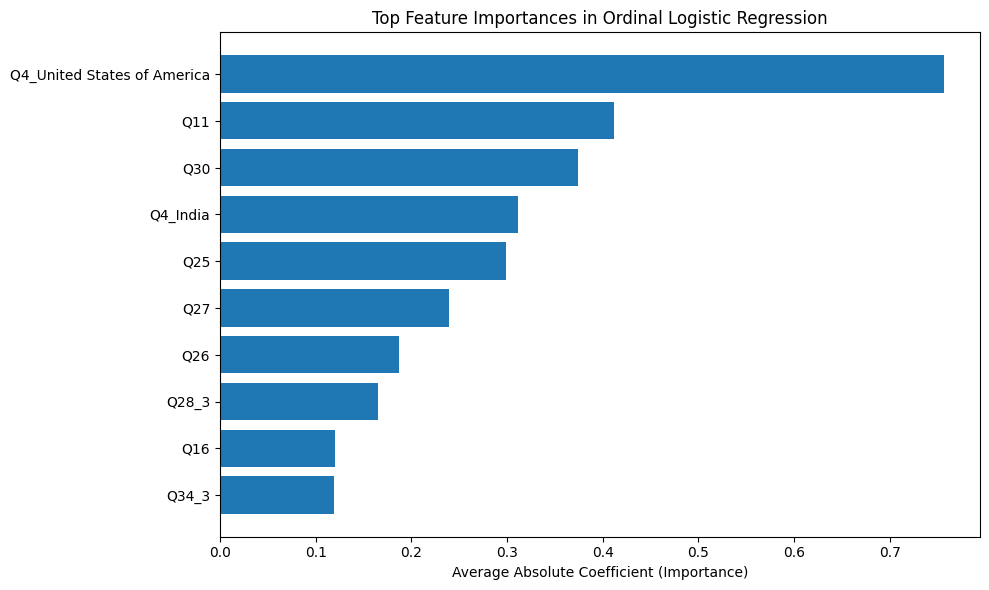

In [176]:
feature_names = train_df_selected.columns

# Collect coefficients from each model
coefs = np.array([np.abs(model_.coef_[0]) for model_ in model.models_])  # shape: (k-1, n_features)

# Average the importance across models
avg_importance = coefs.mean(axis=0)

# Sort by importance
sorted_idx = np.argsort(avg_importance)[::-1]

# Plot top N most important features
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), avg_importance[sorted_idx[:top_n]][::-1])
plt.yticks(range(top_n), [feature_names[i] for i in sorted_idx[:top_n]][::-1])
plt.xlabel("Average Absolute Coefficient (Importance)")
plt.title("Top Feature Importances in Ordinal Logistic Regression")
plt.tight_layout()
plt.show()

# Question 5: Testing

In [177]:
# Using the best-performing model, evaluate the model performance both on the training set and test set

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Evaluate performance
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_qwk = cohen_kappa_score(y_train, y_train_pred, weights="quadratic")
test_qwk = cohen_kappa_score(y_test, y_test_pred, weights="quadratic")

# Print results
print("\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training QWK Score: {train_qwk:.4f}")
print(f"Test QWK Score: {test_qwk:.4f}")

# Compute the difference between train and test performance
accuracy_gap = train_accuracy - test_accuracy
qwk_gap = train_qwk - test_qwk

print("\nOverfitting/Underfitting Analysis:")
print(f"Accuracy Gap (Train - Test): {accuracy_gap:.4f}")
print(f"QWK Score Gap (Train - Test): {qwk_gap:.4f}")

if accuracy_gap > 0.05 or qwk_gap > 0.05:
    print("Possible Overfitting: Training performance is much higher than test performance.")
elif accuracy_gap < -0.05 or qwk_gap < -0.05:
    print("Possible Underfitting: Test performance is better than training performance, model might be too simple.")
else:
    print("Model seems to have a good balance (bias-variance tradeoff).")

# Suggestions for improvement
# print("\nPotential Improvements:")
# print("- If overfitting: Increase regularization (`C` ↓) or add dropout-like noise in features.")
# print("- If underfitting: Increase model complexity (`C` ↑) or tune feature engineering.")
# print("- Try different feature selection strategies to see if it improves performance.")



Model Performance:
Training Accuracy: 0.3906
Test Accuracy: 0.3821
Training QWK Score: 0.4813
Test QWK Score: 0.4782

Overfitting/Underfitting Analysis:
Accuracy Gap (Train - Test): 0.0085
QWK Score Gap (Train - Test): 0.0031
Model seems to have a good balance (bias-variance tradeoff).


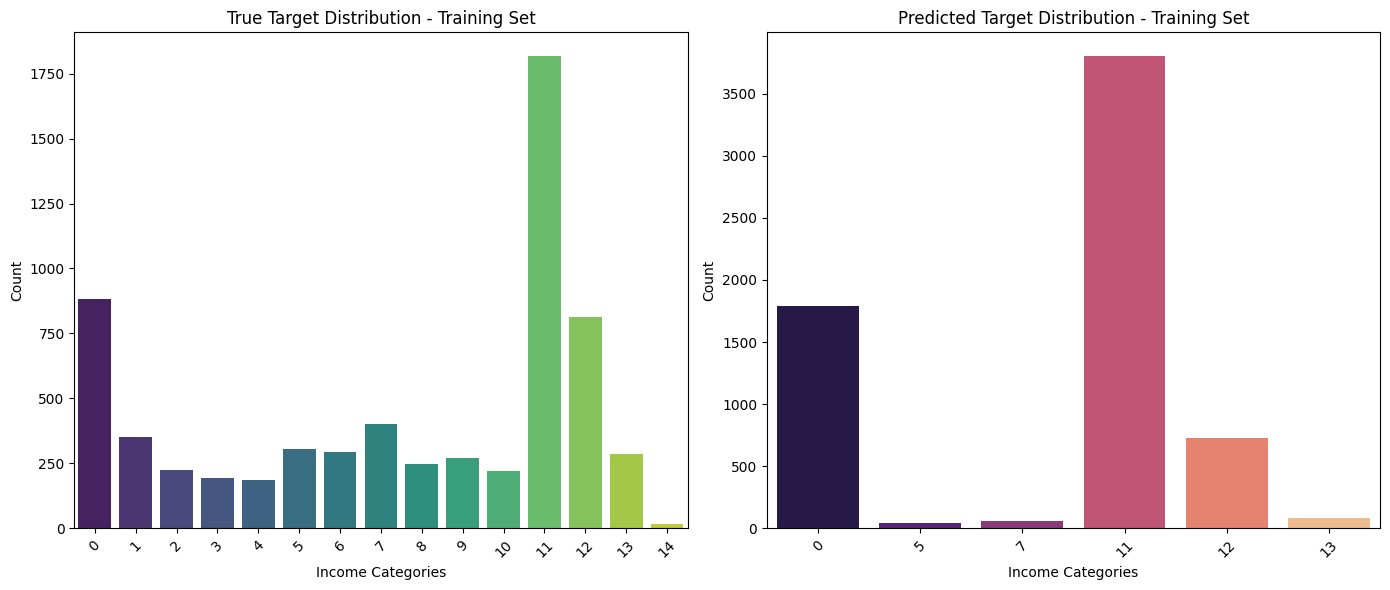

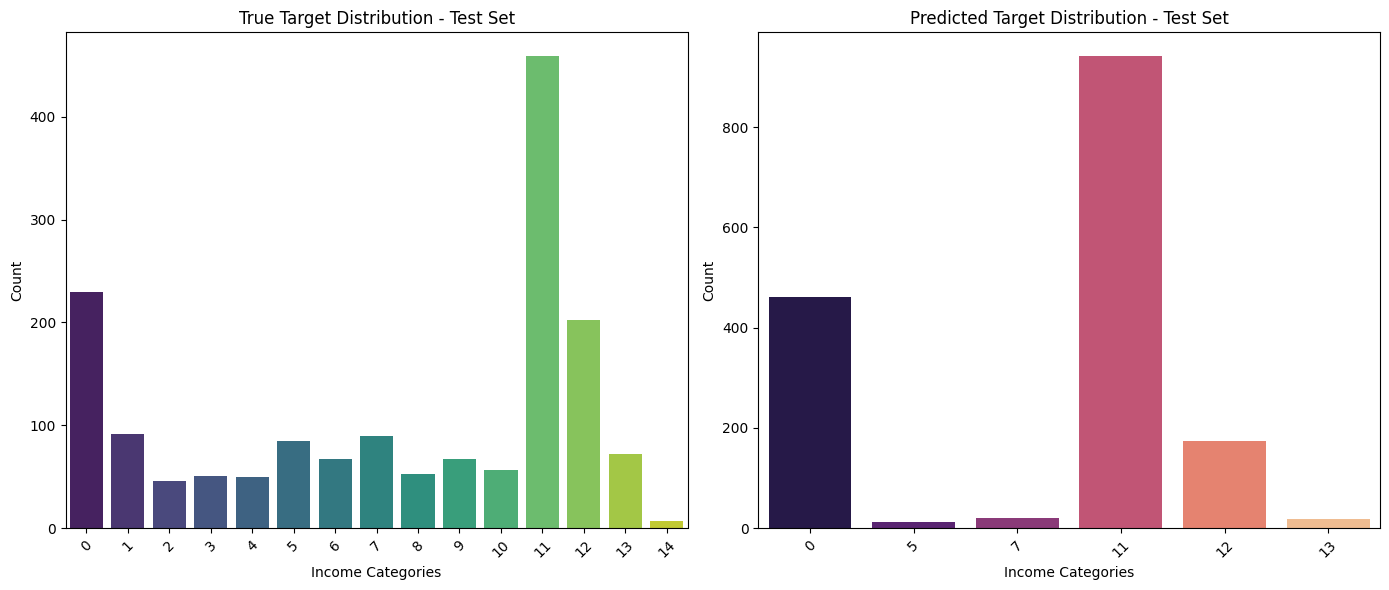

In [178]:
# Plot the distribution of true target variable values and their predictions on both the training set and test set

# Plot distribution on the training set
plt.figure(figsize=(14, 6))

# True target variable distribution on training set
plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette='viridis')
plt.title('True Target Distribution - Training Set')
plt.xlabel('Income Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Predicted target variable distribution on training set
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_pred, palette='magma')
plt.title('Predicted Target Distribution - Training Set')
plt.xlabel('Income Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Plot distribution on the test set
plt.figure(figsize=(14, 6))

# True target variable distribution on test set
plt.subplot(1, 2, 1)
sns.countplot(x=y_test, palette='viridis')
plt.title('True Target Distribution - Test Set')
plt.xlabel('Income Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Predicted target variable distribution on test set
plt.subplot(1, 2, 2)
sns.countplot(x=y_test_pred, palette='magma')
plt.title('Predicted Target Distribution - Test Set')
plt.xlabel('Income Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
